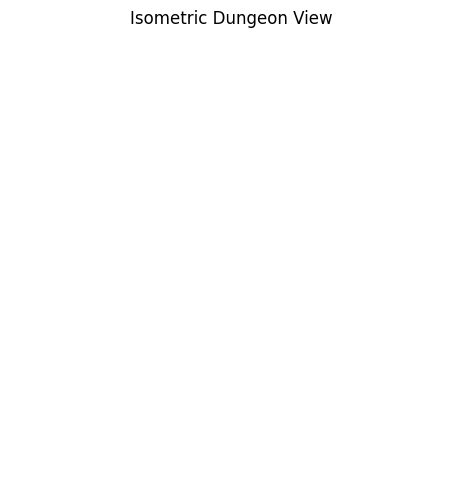

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Regenerate the dungeon and height map
np.random.seed(42)
def generate_dungeon(width, height, room_count=10, room_min=5, room_max=15):
    dungeon = np.zeros((height, width), dtype=int)
    rooms = []
    for _ in range(room_count):
        w = np.random.randint(room_min, room_max)
        h = np.random.randint(room_min, room_max)
        x = np.random.randint(1, width - w - 1)
        y = np.random.randint(1, height - h - 1)
        dungeon[y:y+h, x:x+w] = 1
        rooms.append((x, y, w, h))
    for i in range(1, len(rooms)):
        x1, y1, w1, h1 = rooms[i-1]
        x2, y2, w2, h2 = rooms[i]
        cx1, cy1 = x1 + w1//2, y1 + h1//2
        cx2, cy2 = x2 + w2//2, y2 + h2//2
        if np.random.rand() < 0.5:
            dungeon[min(cy1, cy2):max(cy1, cy2)+1, cx1] = 1
            dungeon[cy2, min(cx1, cx2):max(cx1, cx2)+1] = 1
        else:
            dungeon[cy1, min(cx1, cx2):max(cx1, cx2)+1] = 1
            dungeon[min(cy1, cy2):max(cy1, cy2)+1, cx2] = 1
    return dungeon

width, height = 60, 40
dungeon = generate_dungeon(width, height)
noise = np.random.rand(*dungeon.shape)
for _ in range(5):
    noise = (noise +
             np.roll(noise, 1, axis=0) + np.roll(noise, -1, axis=0) +
             np.roll(noise, 1, axis=1) + np.roll(noise, -1, axis=1)) / 5
height_map = (noise * 10).astype(int) * (dungeon == 1)

# Isometric projection parameters
tile_width, tile_height = 1, 0.5
height_scale = 0.2

fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
ax.set_aspect('equal')
ax.axis('off')

for y in range(height_map.shape[0]):
    for x in range(height_map.shape[1]):
        if dungeon[y, x] == 0:
            continue
        h = height_map[y, x]
        iso_x = (x - y) * tile_width / 2
        iso_y = (x + y) * tile_height / 2 - h * height_scale
        top = (iso_x, iso_y)
        right = (iso_x + tile_width/2, iso_y + tile_height/2)
        bottom = (iso_x, iso_y + tile_height)
        left = (iso_x - tile_width/2, iso_y + tile_height/2)
        tile_poly = Polygon([top, right, bottom, left], closed=True)
        color = plt.cm.viridis(h / height_map.max())
        ax.add_patch(tile_poly)
        tile_poly.set_facecolor(color)
        tile_poly.set_edgecolor('k')
        tile_poly.set_linewidth(0.2)

ax.set_title('Isometric Dungeon View', pad=10)
plt.tight_layout()
plt.show()


## map1

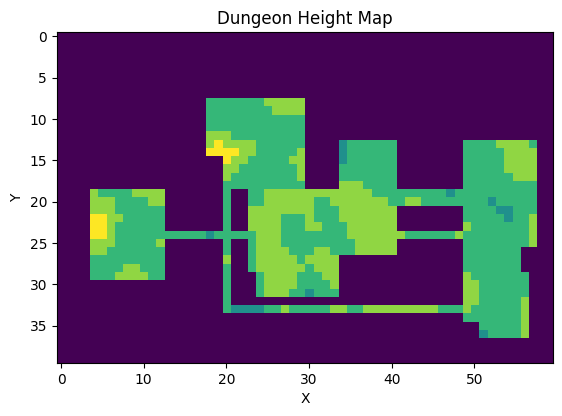

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 간단한 BSP-esque 던전 생성 (방 + 복도)
def generate_dungeon(width, height, room_count=10, room_min=5, room_max=15):
    dungeon = np.zeros((height, width), dtype=int)
    rooms = []
    for _ in range(room_count):
        w = np.random.randint(room_min, room_max)
        h = np.random.randint(room_min, room_max)
        x = np.random.randint(1, width - w - 1)
        y = np.random.randint(1, height - h - 1)
        dungeon[y:y+h, x:x+w] = 1
        rooms.append((x, y, w, h))
    for i in range(1, len(rooms)):
        x1, y1, w1, h1 = rooms[i-1]
        x2, y2, w2, h2 = rooms[i]
        cx1, cy1 = x1 + w1//2, y1 + h1//2
        cx2, cy2 = x2 + w2//2, y2 + h2//2
        if np.random.rand() < 0.5:
            dungeon[min(cy1, cy2):max(cy1, cy2)+1, cx1] = 1
            dungeon[cy2, min(cx1, cx2):max(cx1, cx2)+1] = 1
        else:
            dungeon[cy1, min(cx1, cx2):max(cx1, cx2)+1] = 1
            dungeon[min(cy1, cy2):max(cy1, cy2)+1, cx2] = 1
    return dungeon

# 2. 던전 맵 + 높이 노이즈 생성 및 스무딩
dungeon = generate_dungeon(60, 40)
noise = np.random.rand(*dungeon.shape)
for _ in range(5):
    noise = (noise +
             np.roll(noise, 1, axis=0) + np.roll(noise, -1, axis=0) +
             np.roll(noise, 1, axis=1) + np.roll(noise, -1, axis=1)) / 5

# 3. 높이맵 (0~9) 생성 (벽은 0)
height_map = (noise * 10).astype(int) * (dungeon == 1)

# 4. 타일 유형 결정 (floor, slope_up, cliff, wall)
tile_map = np.full(dungeon.shape, '', dtype=object)
for y in range(height_map.shape[0]):
    for x in range(height_map.shape[1]):
        if dungeon[y, x] == 0:
            tile_map[y, x] = 'wall'
        else:
            h = height_map[y, x]
            diffs = [height_map[(y+dy)%height_map.shape[0], (x+dx)%height_map.shape[1]] - h
                     for dy, dx in [(0,1),(1,0),(0,-1),(-1,0)]]
            max_diff = max(diffs)
            if max_diff > 1:
                tile_map[y, x] = 'cliff'
            elif max_diff == 1:
                tile_map[y, x] = 'slope_up'
            else:
                tile_map[y, x] = 'floor'

# 5. 시각화: 높이맵 히트맵
plt.imshow(height_map)
plt.title('Dungeon Height Map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


## map2

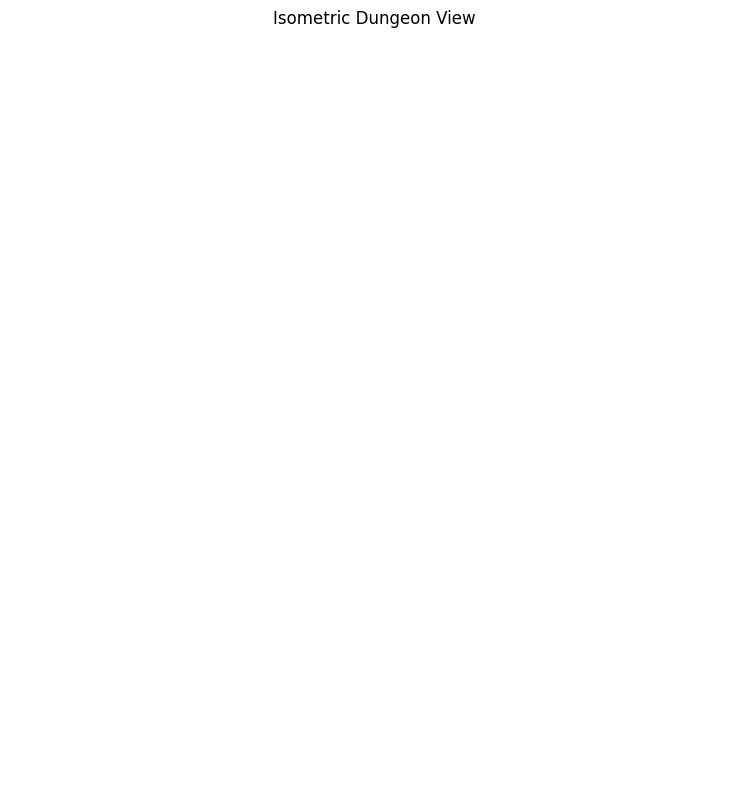

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Set a seed for reproducibility
np.random.seed(42)

# Regenerate the dungeon and height map (same as before)
def generate_dungeon(width, height, room_count=10, room_min=5, room_max=15):
    dungeon = np.zeros((height, width), dtype=int)
    rooms = []
    for _ in range(room_count):
        w = np.random.randint(room_min, room_max)
        h = np.random.randint(room_min, room_max)
        x = np.random.randint(1, width - w - 1)
        y = np.random.randint(1, height - h - 1)
        dungeon[y:y+h, x:x+w] = 1
        rooms.append((x, y, w, h))
    for i in range(1, len(rooms)):
        x1, y1, w1, h1 = rooms[i-1]
        x2, y2, w2, h2 = rooms[i]
        cx1, cy1 = x1 + w1//2, y1 + h1//2
        cx2, cy2 = x2 + w2//2, y2 + h2//2
        if np.random.rand() < 0.5:
            dungeon[min(cy1, cy2):max(cy1, cy2)+1, cx1] = 1
            dungeon[cy2, min(cx1, cx2):max(cx1, cx2)+1] = 1
        else:
            dungeon[cy1, min(cx1, cx2):max(cx1, cx2)+1] = 1
            dungeon[min(cy1, cy2):max(cy1, cy2)+1, cx2] = 1
    return dungeon

width, height = 60, 40
dungeon = generate_dungeon(width, height)
noise = np.random.rand(*dungeon.shape)
for _ in range(5):
    noise = (noise +
             np.roll(noise, 1, axis=0) + np.roll(noise, -1, axis=0) +
             np.roll(noise, 1, axis=1) + np.roll(noise, -1, axis=1)) / 5
height_map = (noise * 10).astype(int) * (dungeon == 1)

# Convert to isometric projection
tile_width, tile_height = 1, 0.5
height_scale = 0.2

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
ax.axis('off')

# Draw each tile
for y in range(height_map.shape[0]):
    for x in range(height_map.shape[1]):
        if dungeon[y, x] == 0:
            continue  # skip walls

        h = height_map[y, x]
        # isometric coordinates
        iso_x = (x - y) * tile_width / 2
        iso_y = (x + y) * tile_height / 2 - h * height_scale

        # corners of the tile
        top = (iso_x, iso_y)
        right = (iso_x + tile_width/2, iso_y + tile_height/2)
        bottom = (iso_x, iso_y + tile_height)
        left = (iso_x - tile_width/2, iso_y + tile_height/2)
        tile_poly = Polygon([top, right, bottom, left], closed=True)

        # color by height
        color = plt.cm.viridis(h / height_map.max())
        ax.add_patch(tile_poly)
        tile_poly.set_facecolor(color)
        tile_poly.set_edgecolor('k')
        tile_poly.set_linewidth(0.2)

ax.set_title('Isometric Dungeon View', pad=20)
plt.tight_layout()
plt.show()
